In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler

import sys
sys.path.append('..')
import selex_dca
import utils, selex_distribution, energy_models, tree, data_loading, training, callback, sampling

In [2]:
experiment_id = "s100"
round_ids = ["5th", "6th", "7th", "8th"]

In [3]:
device = torch.device('cpu')
dtype = torch.float32

In [4]:
sequences = [utils.sequences_from_file_thrombin(experiment_id, round_id, device) for round_id in round_ids]

In [250]:
sequences_oh = [utils.one_hot(seq).to(dtype=dtype) for seq in sequences]
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])
n_rounds = len(sequences_oh) 

In [256]:
tr = tree.Tree()
tr.add_node(-1, name = "6th")
tr.add_node(0, name = "7th")
tr.add_node(1, name = "8th")

selected_modes = torch.BoolTensor(
    [[1], [1], [1]]
)

In [309]:
L, q = sequences_oh[0][0].shape

k = torch.randn(L, q, dtype=dtype) * 1e-4
K = utils.rand_coupling_matrix(L, q, dtype=dtype) * 1e-4
h = torch.randn(L, q, dtype=dtype) * 1e-4
J = utils.rand_coupling_matrix(L, q, dtype=dtype) * 1e-4

Ns0 = energy_models.Potts(K, k)
potts = energy_models.Potts(J, h)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [315]:
batch_size = 10**4
data_loaders_train, data_loaders_valid = data_loading.train_test_split(sequences_oh, batch_size, [0.7, 0.3], device)

In [316]:
n_chains = 10**3
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [317]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [341]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 1000

training.train(model, data_loaders_train, total_reads, chains, n_sweeps, max_epochs, target_pearson, lr=lr, 
               callbacks=callbacks, log_weights=log_weights, data_loaders_valid=data_loaders_valid)

 0.00%[                                                        ] Epoch: 0/1000 [00:00, ?it/s]

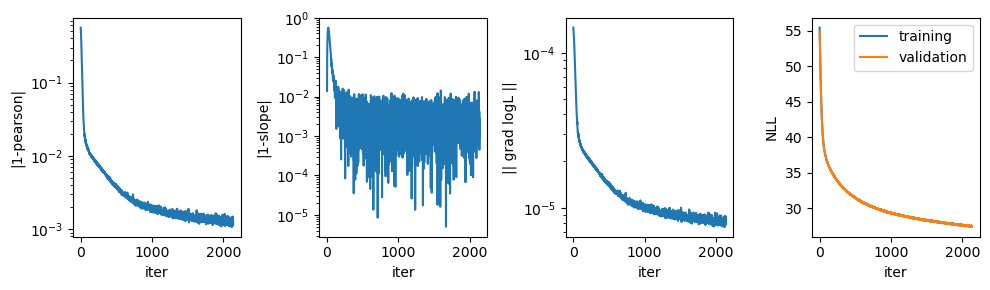

In [342]:
callbacks[0].plot();

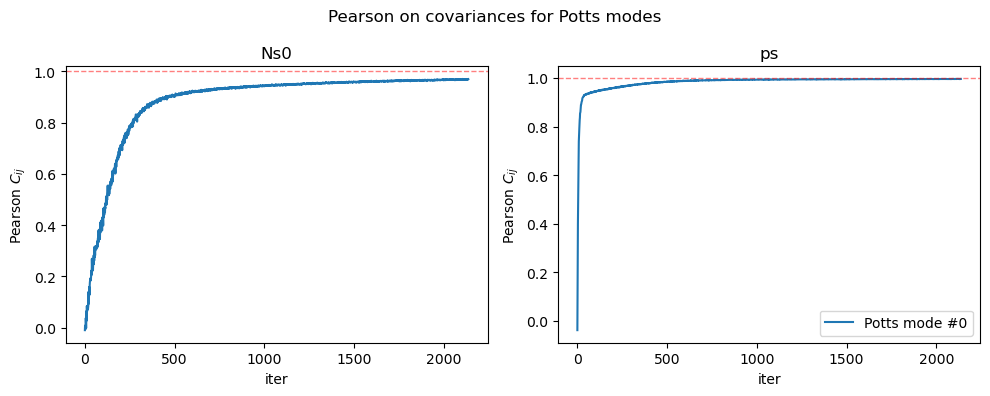

In [343]:
callbacks[1].plot();

## Look at learned parameters

In [344]:
potts_Ns0_zerosum = Ns0.set_zerosum_gauge()
potts_sel_zerosum = potts.set_zerosum_gauge()

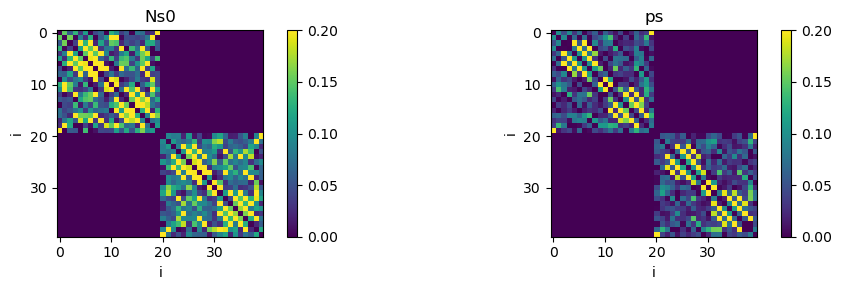

In [345]:
from IPython.display import display, Latex

pl, axes = plt.subplots(1, 2, figsize=(10,3))

J_Ns0 = potts_Ns0_zerosum.J.detach()
F = selex_dca.get_contact_map(J_Ns0)
im = axes[0].imshow(F)
axes[0].set_xlabel("i"); axes[0].set_ylabel("i")
axes[0].set_title("Ns0")
plt.colorbar(im)
im.set_clim(0,0.2)

J_ps = potts_sel_zerosum.J.detach()
F = selex_dca.get_contact_map(J_ps)
im = axes[1].imshow(F)
axes[1].set_xlabel("i"); axes[1].set_ylabel("i")
axes[1].set_title("ps")
plt.colorbar(im)
plt.tight_layout()
im.set_clim(0,0.2)

In [346]:
def _select(A, idx):
    A2 = A.index_select(0, torch.tensor(idx))
    return A2.index_select(2, torch.tensor(idx))
    
idx_left = range(0, 20)
idx_right = range(20, 40)

J_ps_left = _select(J_ps, idx_left)
J_ps_right = _select(J_ps, idx_right)
J_Ns0_left = _select(J_Ns0, idx_left)
J_Ns0_right = _select(J_Ns0, idx_right)

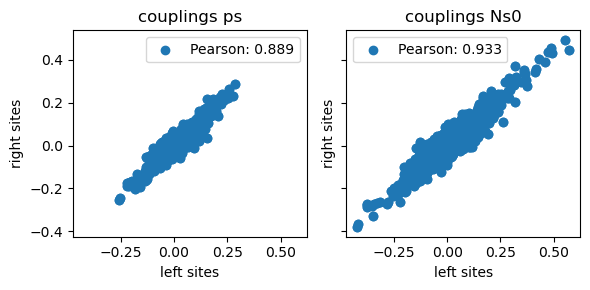

In [347]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,3), sharex=True, sharey=True)
ax = ax1
x = J_ps_left.view(-1)
y = J_ps_right.view(-1)
rho = torch.corrcoef(torch.stack((x,y)))[0,1]
ax.scatter(x, y, label=f"Pearson: {rho:.3f}")
ax.set_xlabel("left sites")
ax.set_ylabel("right sites")
ax.set_title("couplings ps")
ax.legend()

ax = ax2
x = J_Ns0_left.view(-1)
y = J_Ns0_right.view(-1)
rho = torch.corrcoef(torch.stack((x,y)))[0,1]
ax.scatter(x, y, label=f"Pearson: {rho:.3f}")
ax.set_xlabel("left sites")
ax.set_ylabel("right sites")
ax.set_title("couplings Ns0")
ax.legend()

plt.tight_layout()

## Binned log likelihood

In [348]:
sequences_unique_all, counts_unique, enrichments = utils.unique_sequences_counts_enrichments(sequences)

Extracting unique sequences and counts at each round...
Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round 0...
	Starting round 1...
	Starting round 2...
	Starting round 3...
Calculating enrichments...
Finished


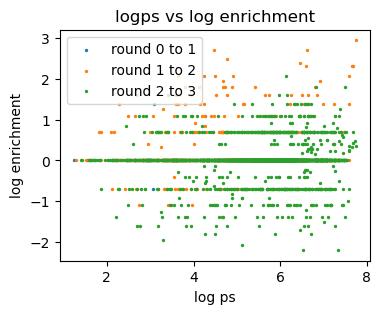

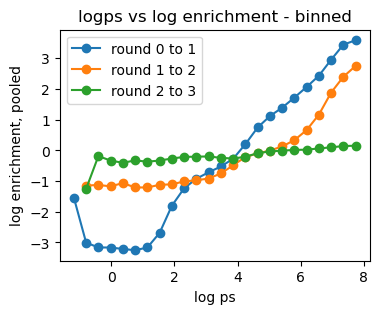

In [349]:
utils.binned_logenrichments(model, sequences_unique_all_oh, enrichments, counts_unique, 
                            n_bins = 25, plot=True, thresh=0.0, n_subsample=10**6);

In [351]:
logNst_unique = [- model.compute_energy_up_to_round(sequences_unique_all_oh, t).detach()
                for t in range(n_rounds)]

Text(0.5, 1.0, 'logNst vs log count')

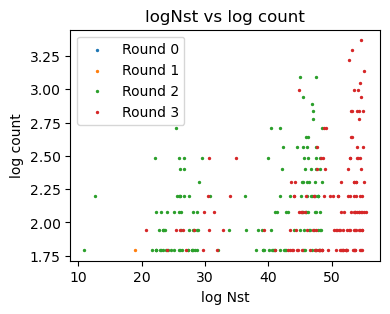

In [356]:
# n_seq = len(sequences_unique_all_oh)
# idx = random.sample(range(n_seq), min(n_subsample, n_seq))
count_thresh = 5
fig1, ax = plt.subplots(figsize=(4,3))
for t in range(n_rounds):
    idx = counts_unique[t] > count_thresh
    ax.scatter(logNst_unique[t][idx], torch.log(counts_unique[t][idx]), 
               label=f'Round {t}', s=2)
    ax.set_xlabel('log Nst')
    ax.set_ylabel('log count')
    ax.legend()
ax.set_title('logNst vs log count')

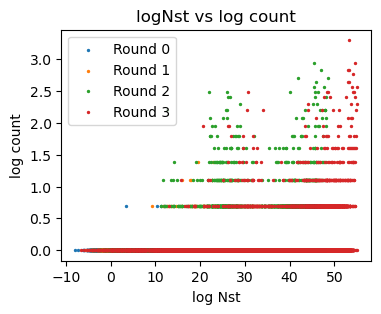

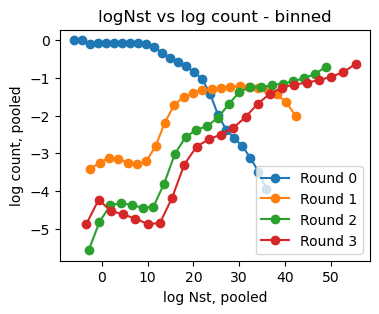

In [350]:
utils.binned_logcounts(model, sequences_unique_all_oh, counts_unique, 
                       n_bins = 25, plot=True, thresh=0.0, n_subsample=10**6);